In [1]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import umap

# Set Device and Random State
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.has_mps:
    device = 'mps'
print(device)
torch.manual_seed(189898)

cuda


In [2]:
def get_pbmc(perc_labels = 0.1):
    X = np.loadtxt("../data/ATAC_scaledata.txt")
    true_labels = np.loadtxt("../data/ATAC_type.txt")
    true_labels = true_labels.astype(int)
    
    # Select some labels to remove for the experiments
    targets = true_labels.copy().astype(float)
    for p, i in enumerate(np.unique(true_labels)):
        indx = np.where(true_labels == i)[0]
        # from the observations with this label take a % off
        NlabelsRemove = int(np.floor(len(indx)*(1-perc_labels)))
        indxR = np.random.choice(indx, NlabelsRemove, replace=False)
        targets[indxR] = 'nan'
    test_ind = np.where(torch.isnan(torch.tensor(targets)))[0]
    return X, true_labels, targets, test_ind

X, true_labels, targets, test_ind = get_pbmc(perc_labels=0.01)

In [3]:
Embedding = umap.UMAP(n_neighbors=20, n_components = 5, min_dist=0.01).fit_transform(X)

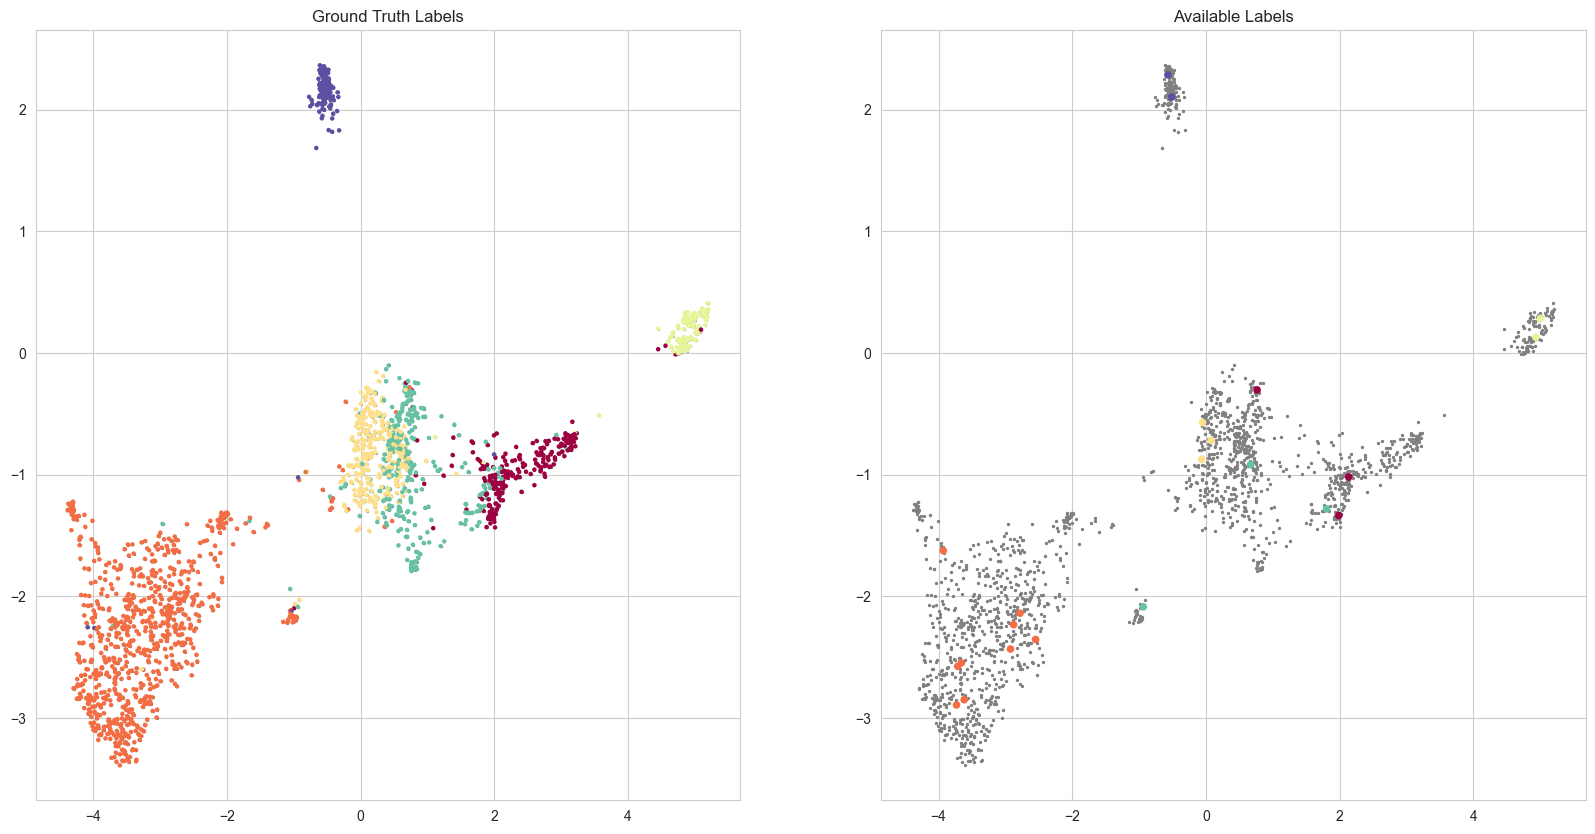

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.scatter(Embedding[:,0], Embedding[:,1], c='grey', s=2)
ax1.scatter(Embedding[:,0], Embedding[:,1], c=true_labels, s=5, cmap='Spectral')
ax1.set_title("Ground Truth Labels")
ax2.scatter(Embedding[:,0], Embedding[:,1], c='grey', s=2)
ax2.scatter(Embedding[:,0], Embedding[:,1], c=targets, s=20, cmap='Spectral')
ax2.set_title("Available Labels")
plt.show()

In [5]:
print(Embedding)

[[ 2.8217373  -0.93540925  3.1755736   5.0950274   3.2243333 ]
 [ 1.9129577  -1.0691277   4.8838167   5.1976767   3.9937901 ]
 [ 0.70683163 -0.39362407  4.3093224   5.40825     3.778862  ]
 ...
 [ 5.1790814   0.33847988  2.9227912   5.1839933   3.1196933 ]
 [-3.4938245  -2.1667693   0.5152767   6.796434    3.709842  ]
 [ 0.71552914 -0.86354345  2.9789045   6.5339885   2.8820186 ]]


In [6]:
class MultiTaskModule(nn.Module):
    '''This module should be able to take any number of layers and dimensions. For instance, 
    if hidden_dims = [100, 100] the architecture should have two hidden layers with 100 neurons each. 
    If hidden_dims = [200, 100, 80] your code should generate 3 hidden layers.'''
    
    def __init__(self, input_dim, hidden_dims, z_dim, output_dim):
        super().__init__()

        self.layers = [nn.Linear(input_dim, hidden_dims[0])]
        
        for i in range(len(hidden_dims)-1):
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        
        self.layers.append(nn.Linear(hidden_dims[-1], output_dim))
        self.classifier = nn.ModuleList(self.layers)
        
        
        self.R_layers = []
        for i in range(len(hidden_dims)):
            self.R_layers.append(nn.Linear(hidden_dims[i], z_dim))
            
        self.regularization = nn.ModuleList(self.R_layers)
        self.nl = nn.ReLU()
        # self.lact = nn.Softmax()
               
    def forward(self, x, noise = 0):
        
        C = []
        for i, l in enumerate(self.classifier):
            if i < 1:          
                x = l(x)
            elif  i == len(self.classifier)-1: 
                # x = self.lact(l(x))
                x = l(x)
            else:
                x = self.nl(l(x))
            C.append(x)
        
        R = []
        for i, l in enumerate(self.regularization):
            x = l(C[i])
            R.append(x)
        
        '''The output of the forward pass should be a list "R" that contains all the mappings from the inner layers to 
        the reference embeddings, and a classification activations'''
        return R, C[-1]
    



In [7]:
'''This class '''
class dataset_ss(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y
        def __len__(self):
            return len(self.X)   
        def __getitem__(self, idx):
            return self.X[idx], self.y[idx], idx

In [8]:
class GRNN():
    """Geometry regularized neural network"""
    def __init__(self, *, 
                 lr=1e-4, 
                 epochs=1000, 
                 batch_size=64, 
                 weight_decay=0,
                 hidden_dims=[100, 100, 100], 
                 lam = 0,
                 dev = 'cpu'):
        
        # The learning rate for the optimizer 
        self.lr = lr
        
        # number of epochs and batch size
        self.epochs = epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        
        # dimension of the hidden layers
        self.hidden_dims = hidden_dims  
        
        # Regularization parameter to recover the reference embedding 
        self.lam = lam
        
        '''***define the classification criterion***'''
        self.criterion_reg = nn.MSELoss()
        self.criterion_cla = nn.CrossEntropyLoss()

        self.device = dev
        
    def fit(self, X, E, y):
        '''X is your features, E the reference embedding, y your targets.'''           
        self.y = torch.Tensor(y)
        self.X = torch.tensor(X).float() 

        
        self.shape = X.shape
        input_size = self.shape[1]
        self.E = torch.tensor(E).float()
        
        # extracting the data with labels 
        idx2 = torch.where(~torch.isnan(self.y))[0]
        self.E_labels = self.E[idx2,:]
        self.data_labels = self.X[idx2,:]
        self.y_labels = self.y[idx2].long()
        self.n_classes = len(torch.unique(self.y_labels))
        
        
        # create the torch module        
        self.torch_module = MultiTaskModule(input_dim=input_size, output_dim = self.n_classes,
                                                  hidden_dims=self.hidden_dims,
                                                  z_dim=E.shape[1])
        self.torch_module.to(self.device)
        self.torch_module.train()

            
        # define the optimizer
        self.optimizer = torch.optim.Adam(self.torch_module.parameters(),
                                          lr=self.lr,
                                          weight_decay=self.weight_decay)
        
        
        
        data_set = dataset_ss(self.X, self.y)    
        self.loader = self.get_loader(data_set)
        
        
        for epoch in range(self.epochs):
            for batch in self.loader:
                self.optimizer.zero_grad()
                self.train(batch)
                self.optimizer.step()
            if (epoch+1) % 100 == 0 or epoch==0:
                print(f"Epoch {epoch+1} out of {self.epochs} ==== Loss: {self.loss.item()} \n {self.loss_manf.item()}")
                
    def get_loader(self, X):
        return torch.utils.data.DataLoader(X, batch_size=self.batch_size, shuffle=False)

    def train(self, batch):
        
        x, y, idx = batch
        '''*** Complete the computation of the loss and as the last step of this train function call loss.backward() 
        remember you will need self.criterion_reg and self.criterion_cla
        ***
        '''
        
        x = torch.cat((x, self.data_labels))
        y = torch.cat((y, self.y_labels))
        E = torch.cat((self.E[idx], self.E_labels))
        idx2 = torch.where(~torch.isnan(y))[0]
        
        x = x[idx2]
        y = y[idx2].long()
        E = E[idx2]
        
        x = x.to(self.device) 
        y = y.to(self.device)
        E = E.to(self.device)
        reg_N, y_hat = self.torch_module(x)
        
        reg_N = reg_N[0]
        classification_loss = self.criterion_cla(y_hat, y)
        manifold_loss = self.criterion_reg(reg_N, E)
        total_loss = classification_loss + self.lam * manifold_loss
        
        self.loss = total_loss
        self.loss_manf = manifold_loss
        self.loss.backward()
        
    def predict(self, X):
        reg_N, y_hat = self.torch_module(torch.tensor(X).float().to(self.device))
        y_hat = y_hat.argmax(1).detach().cpu().numpy()
        reg_N = [i.detach().cpu().numpy() for i in reg_N]
        return reg_N, y_hat

In [9]:
# Let's have a quick test with and without regularization
# lam = 0 means the geometry regularization plays no role and we have the vanilla NN

model = GRNN(epochs = 500, lam = 0, dev=device)
model.fit(X, Embedding, targets)
En, y_hat = model.predict(X)

Epoch 1 out of 500 ==== Loss: 1.697519302368164 
 13.20960807800293
Epoch 100 out of 500 ==== Loss: 0.00011404829274397343 
 13.096620559692383
Epoch 200 out of 500 ==== Loss: 1.2663181223615538e-05 
 13.08743667602539
Epoch 300 out of 500 ==== Loss: 2.064485670416616e-06 
 13.080825805664062
Epoch 400 out of 500 ==== Loss: 3.251161899697763e-07 
 13.07556438446045
Epoch 500 out of 500 ==== Loss: 2.7093017607171532e-08 
 13.072580337524414


In [10]:
# lam = 1 imposes the regularization

model = GRNN(epochs = 500, lam = 1,  hidden_dims = [100, 80, 30])
model.fit(X, Embedding, targets)
En_r, y_hat_r = model.predict(X)

Epoch 1 out of 500 ==== Loss: 14.926252365112305 
 13.139289855957031
Epoch 100 out of 500 ==== Loss: 0.00033428825554437935 
 1.9697208131219668e-07
Epoch 200 out of 500 ==== Loss: 3.783325519179925e-05 
 1.5325236635277406e-09
Epoch 300 out of 500 ==== Loss: 6.220584509719629e-06 
 5.255104684742662e-11
Epoch 400 out of 500 ==== Loss: 1.105397359424387e-06 
 2.9260068760278424e-12
Epoch 500 out of 500 ==== Loss: 1.9702653730746533e-07 
 1.9568084930199348e-09


0.5631756886302589
0.514533562035021


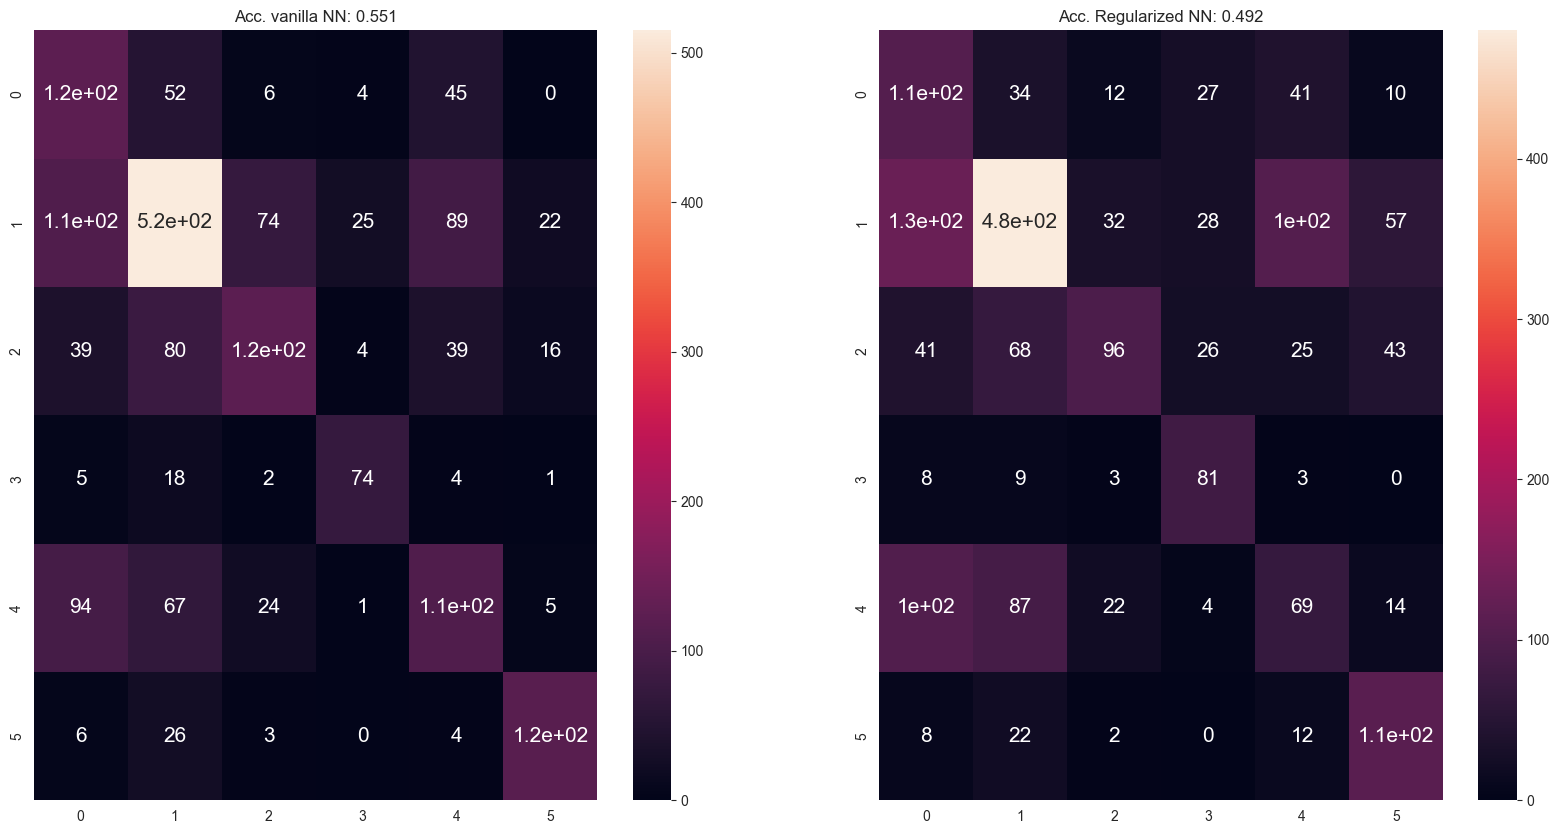

In [11]:
acc = sklearn.metrics.accuracy_score(true_labels, y_hat)
print(sklearn.metrics.balanced_accuracy_score(true_labels, y_hat))
cm = sklearn.metrics.confusion_matrix(true_labels, y_hat)
df_cm = pd.DataFrame(cm, range(6), range(6))

acc_r = sklearn.metrics.accuracy_score(true_labels, y_hat_r)
print(sklearn.metrics.balanced_accuracy_score(true_labels, y_hat_r))
cm = sklearn.metrics.confusion_matrix(true_labels, y_hat_r)
df_cm_r = pd.DataFrame(cm, range(6), range(6))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 15}, ax = ax1) 
ax1.set_title(f"Acc. vanilla NN: {acc:.3f}")
sns.heatmap(df_cm_r, annot=True, annot_kws={"size": 15}, ax = ax2) 
ax2.set_title(f"Acc. Regularized NN: {acc_r:.3f}")
plt.show()

In [12]:
# SEEDS = [111]
# plabels = np.array([0.01, 0.05])
# lambdas = [0, 1]
# RUNS = 10


# pandas data frame to store the results
# columns_names = ["Model", "Dataset", "Test acc", "Labeled percentage", "Number of Layers", "RUN"]
# inds = []
# df = pd.DataFrame(data=None, index=inds, columns=columns_names, 
#                   dtype=None, copy=False)
#     for per_labels in plabels:
#         for run in range(RUNS):
#             X, true_labels, targets, test_ind = get_pbmc(perc_labels = 0.02)
#             Embedding = umap.UMAP(n_neighbors=20, n_components = 5, min_dist=0.01).fit_transform(X)
#             for lamb in lambdas: